LSTM model에 따른 gradient problem observation

input_size, output_size 1로 고정시키고
batch_size, hidden_size, sequence_length를 점진적으로 변화.
이 때 계산의 복잡성이 너무 커지는것 및 의미있는 모델 유지를 위해 Validation Set에 대한 Error를 기준으로 epochs수 조정(Early Stopping 활용)


In [4]:
import torch
import torch.nn as nn
import numpy as np


# LSTM 모델 정의
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.linear(output[-1])
        return output
    
# 얼리스타핑을 위한 함수 정의
def early_stopping(validation_losses, patience):
    # 최근 patience 에폭 동안 검증 손실이 감소하지 않으면 True 반환
    if len(validation_losses) > patience and validation_losses[-1] > min(validation_losses[-patience:-1]):
        return True
    return False

input_size = 1
output_size = 1
# 수정된 실험 파라미터 설정
batch_sizes = list(range(16,512,10)) # 배치 크기 범위
hidden_sizes = list(range(10,100,10))  # 은닉 상태 크기 범위
max_seq_length = 1000  # 최대 시퀀스 길이 설정
seq_length_increment = 50  # 시퀀스 길이 증가 간격
patience = 3  # 얼리스타핑 인내심 (연속적으로 성능이 개선되지 않을 때까지의 에폭 수)

# 그라디언트 문제 감지를 위한 임계값 설정
max_gradient_norm = 100.0  # 그라디언트 폭발 임계값
min_gradient_norm = 0.001  # 그라디언트 소실 임계값

# 실험 결과를 저장할 딕셔너리
experiment_results = {}

# 실험 진행
for batch_size in batch_sizes:
    for hidden_size in hidden_sizes:
        seq_length = 50
        while seq_length <= max_seq_length:
            # 데이터 생성 (학습 및 검증 세트 분리)
            data_x = torch.randn(seq_length, batch_size, input_size)
            data_y = torch.randn(batch_size, output_size)
            split_idx = int(batch_size * 0.8)  # 학습 세트 80%, 검증 세트 20%
            train_x, val_x = data_x[:, :split_idx, :], data_x[:, split_idx:, :]
            train_y, val_y = data_y[:split_idx, :], data_y[split_idx:, :]

            # 모델 초기화
            model = SimpleLSTM(input_size, hidden_size, output_size)
            loss_function = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            validation_losses = []
            for epoch in range(50):  # 최대 에폭 50
                # 학습
                model.train()
                optimizer.zero_grad()
                train_output = model(train_x)
                train_loss = loss_function(train_output, train_y)
                train_loss.backward()
                optimizer.step()

                # 검증
                model.eval()
                with torch.no_grad():
                    val_output = model(val_x)
                    val_loss = loss_function(val_output, val_y)
                validation_losses.append(val_loss.item())

                # 얼리스타핑 체크
                if early_stopping(validation_losses, patience):
                    break

            # 그라디언트 폭발 또는 소실 체크
            gradients = np.array([p.grad.norm().item() for p in model.parameters() if p.grad is not None])
            if np.any(gradients > max_gradient_norm) or np.any(gradients < min_gradient_norm):
                experiment_results[(batch_size, hidden_size, seq_length)] = "Gradient Problem Detected"
                break
            else:
                experiment_results[(batch_size, hidden_size, seq_length)] = "No Problem"
                seq_length += seq_length_increment

# 실험 결과 요약
experiment_results



{(16, 10, 50): 'No Problem',
 (16, 10, 100): 'No Problem',
 (16, 10, 150): 'No Problem',
 (16, 10, 200): 'No Problem',
 (16, 10, 250): 'No Problem',
 (16, 10, 300): 'No Problem',
 (16, 10, 350): 'No Problem',
 (16, 10, 400): 'No Problem',
 (16, 10, 450): 'No Problem',
 (16, 10, 500): 'No Problem',
 (16, 10, 550): 'No Problem',
 (16, 10, 600): 'No Problem',
 (16, 10, 650): 'No Problem',
 (16, 10, 700): 'No Problem',
 (16, 10, 750): 'No Problem',
 (16, 10, 800): 'No Problem',
 (16, 10, 850): 'No Problem',
 (16, 10, 900): 'No Problem',
 (16, 10, 950): 'Gradient Problem Detected',
 (16, 20, 50): 'No Problem',
 (16, 20, 100): 'No Problem',
 (16, 20, 150): 'No Problem',
 (16, 20, 200): 'No Problem',
 (16, 20, 250): 'No Problem',
 (16, 20, 300): 'No Problem',
 (16, 20, 350): 'No Problem',
 (16, 20, 400): 'No Problem',
 (16, 20, 450): 'No Problem',
 (16, 20, 500): 'No Problem',
 (16, 20, 550): 'No Problem',
 (16, 20, 600): 'No Problem',
 (16, 20, 650): 'No Problem',
 (16, 20, 700): 'No Problem

결과값 dataframe 만들기

In [6]:
import pandas as pd
# experiment_results 딕셔너리의 키를 분해하여 개별 열로 만듭니다.
data = {
    'Batch Size': [key[0] for key in experiment_results.keys()],
    'Hidden Size': [key[1] for key in experiment_results.keys()],
    'Seq Length': [key[2] for key in experiment_results.keys()],
    'Gradient Problem': list(experiment_results.values())
}

# 데이터프레임 생성
experiment_df = pd.DataFrame(data)
#File export
experiment_df.to_pickle("df_lstm.pkl")



In [10]:
experiment_df.to_pickle("C:/Users/galax/Downloads/df_lstm.pkl")

만약 두번째에 실행시 위의 학습과정을 거치지 말고 아래 데이터 프레임을 받아와서 바로 활용 (위의 학습과정이 매우 오래걸림), 구글 드라이브에 데이터프레임 공유

In [ ]:
import pandas as pd
url="https://drive.google.com/file/d/1N7-16jAYCaxNydoFFy9DI_nWfXI1b1gT/view?usp=sharing"
path='https://drive.google.com/uc?id='+url.split('/')[-2]
print("▶ 공유파일 링크변환 경로명 : ", path)
df=pd.read_csv(path)
df.head()

In [ ]:
experiment_df = pd.read_pickle("C:/Users/galax/Downloads/df_lstm.pkl")

그래프 시각화

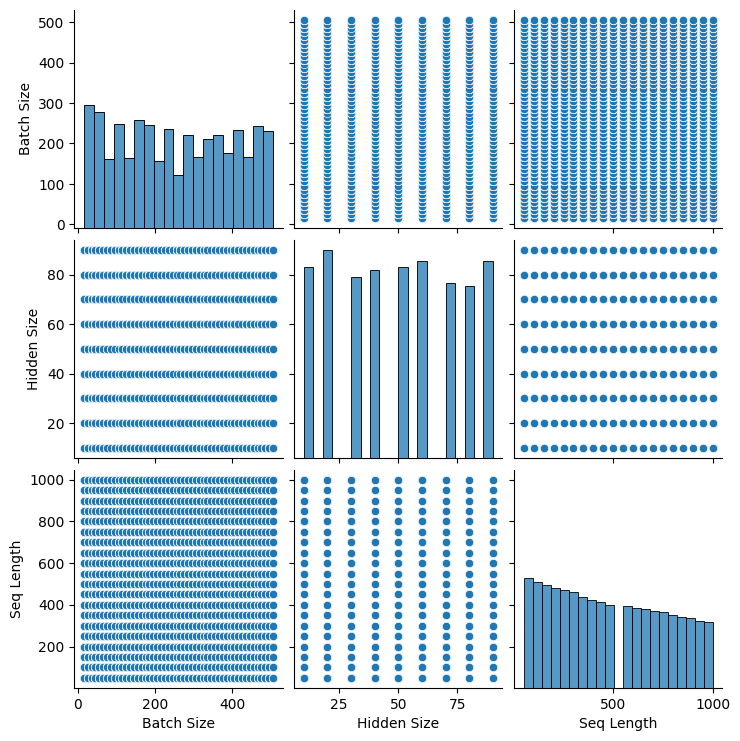

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(experiment_df); 
plt.show()

로지스틱 회귀분석 진행

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# 데이터프레임 내의 'Gradient Problem' 컬럼을 이진 값으로 변환 (No Problem: 0, Gradient Problem Detected: 1)
experiment_df['Gradient Problem'] = experiment_df['Gradient Problem'].apply(lambda x: 0 if x == 'No Problem' else 1)

# 독립 변수와 종속 변수 분리
X = experiment_df[['Batch Size', 'Hidden Size', 'Seq Length']]
y = experiment_df['Gradient Problem']

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 데이터 표준화 (스케일링)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 로지스틱 회귀 모델 생성 및 훈련
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# 테스트 세트에 대한 예측 및 성능 평가
predictions = model.predict(X_test_scaled)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

# 로지스틱 회귀 모델의 계수 출력
print("Model Coefficients:", model.coef_)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1371
           1       0.00      0.00      0.00        26

    accuracy                           0.98      1397
   macro avg       0.49      0.50      0.50      1397
weighted avg       0.96      0.98      0.97      1397

[[1371    0]
 [  26    0]]
Model Coefficients: [[ 0.17916104  0.05760315 -0.12224161]]


c:\Users\galax\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\galax\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\galax\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

새로운 값 넣어서 예측해보기

In [15]:
new_batch_size = int(input('Input new_batch_size : '))
new_hidden_size = int(input('Input new_hidden_size : ')) 
new_seq_length = int(input('Input new_seq_length :'))
# 새로운 입력 값
new_data = [[new_batch_size, new_hidden_size, new_seq_length]]

# 입력 데이터 표준화
new_data_scaled = scaler.transform(new_data)  # scaler는 이전에 학습 데이터를 표준화하는 데 사용된 객체

# 예측 수행
prediction = model.predict(new_data_scaled)

# 예측 결과 해석
predicted_status = "No Problem" if prediction[0] == 0 else "Gradient Problem Detected"
print(predicted_status)

No Problem


c:\Users\galax\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
